In [1]:

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from pathlib import Path
import pandas as pd

In [2]:
path = Path("/Users/jaimesastrecrespo/DAFT_1022/Final_project/spotify_App")

In [3]:
with open(path / "client_s.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content]


In [4]:
client_id = content[0]
client_secret = content[1]
redirect_uri = 'http://127.0.0.1:8080/yep'
username = content[3]


In [5]:
scope = "user-library-read user-read-recently-played user-top-read playlist-modify-public playlist-read-private playlist-read-collaborative"


In [6]:

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [7]:
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [8]:
results_fav_songs = sp.current_user_top_tracks(limit = 50,offset=0,time_range='short_term')

In [9]:
from spotifuncs2 import create_df_top_songs, append_audio_features , authenticate, create_df_recommendations

In [10]:
top_tracks_short = sp.current_user_top_tracks(limit = 50,offset=0,time_range='short_term')
top_tracks_med = sp.current_user_top_tracks(limit = 50,offset=0,time_range='medium_term')
top_tracks_long = sp.current_user_top_tracks(limit = 50,offset=0,time_range='long_term')

#combine the top_tracks
top_tracks_short_df = append_audio_features(create_df_top_songs(top_tracks_short),sp)
top_tracks_med_df = append_audio_features(create_df_top_songs(top_tracks_med),sp)
top_tracks_long_df = append_audio_features(create_df_top_songs(top_tracks_long),sp)

top_tracks_short_df["Timeframe"] = "short term"
top_tracks_med_df["Timeframe"] = "medium term"
top_tracks_long_df["Timeframe"] = "long term"

top_tracks = pd.concat([top_tracks_short_df, top_tracks_med_df, top_tracks_long_df])
top_tracks = top_tracks.reset_index(drop = True)


In [11]:
top_tracks

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Timeframe
0,My Hero,The Colour And The Shape,4dVbhS6OiYvFikshyaQaCN,Foo Fighters,260026,75,0.398,0.927,9,-4.212,1,0.0567,0.000062,0.000177,0.0575,0.311,77.106,short term
1,Everlong,The Colour And The Shape,5UWwZ5lm5PKu6eKsHAGxOk,Foo Fighters,250546,83,0.413,0.881,11,-5.541,0,0.0367,0.000060,0.000308,0.0805,0.364,158.066,short term
2,MAN ON THE MOON,TM,3UdquFlgsSBKueNRHgjOiG,BROCKHAMPTON,240600,64,0.736,0.737,7,-7.726,1,0.0437,0.073200,0.631000,0.1090,0.534,145.006,short term
3,Best of You,In Your Honor,5FZxsHWIvUsmSK1IAvm2pp,Foo Fighters,255626,75,0.366,0.940,1,-5.119,0,0.0696,0.000769,0.000094,0.1880,0.369,130.198,short term
4,No L's,Luv 4 Rent,12CNybio0Bxean3F3uYugU,Smino,175018,68,0.786,0.650,1,-6.472,1,0.3100,0.156000,0.000000,0.1270,0.492,130.993,short term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rockadown Subway Session,Rockadown Subway Session,3bdhZxL276JwNlNsQgu51s,Vanupié,214041,0,0.650,0.648,6,-6.694,0,0.3390,0.525000,0.000000,0.6830,0.792,140.607,long term
146,Je veux,Zaz,734dz1YaFITwawPpM25fSt,Zaz,215933,68,0.525,0.807,2,-6.366,0,0.0725,0.251000,0.000000,0.0504,0.741,155.397,long term
147,Redemption Song,Uprising,26PwuMotZqcczKLHi4Htz3,Bob Marley & The Wailers,233560,69,0.671,0.256,7,-10.743,1,0.0387,0.608000,0.000000,0.0737,0.694,115.871,long term
148,Last Kiss,Last Kiss,0QnONzv3TvHAWk294h6DaQ,Pearl Jam,195466,71,0.622,0.692,7,-6.970,1,0.0276,0.363000,0.000158,0.1930,0.774,112.053,long term


### Recommendation 

In [12]:
seed_tracks = top_tracks["track_id"].tolist()

In [13]:
len(seed_tracks)

150

The SpotifyAPI only accepts a small list of seed tracks for each query which is unfortunate as I wanted to use the whole playlit as a seed for the recommendations. I worked around this by using "packages" of 5 seed tracks to retrieve 25 recommendations (basically 5 per song).

In [14]:
sp_m = authenticate(redirect_uri, client_credentials_manager, username, scope, client_id, client_secret)


In [15]:
recomm_dfs = []
for i in range(5,len(seed_tracks)+1,5):
    recomms = sp_m.recommendations(seed_tracks = seed_tracks[i-5:i],limit = 10)
    recomms_df = append_audio_features(create_df_recommendations(recomms),sp_m)
    recomm_dfs.append(recomms_df)
recomms_df = pd.concat(recomm_dfs)
recomms_df.reset_index(drop = True, inplace = True)

In [16]:

recomms_df

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Mad Funny Freestyle,TWOPOINTFIVE,2pGz1Afwxe0KHJtJLwm0Kd,Aminé,101744,60,0.833,0.610,9,-7.556,0,0.3020,0.04720,0.000010,0.3190,0.793,147.945
1,Shine,"Hints, Allegations & Things Left Unsaid",77YKoNCjP5hWqiXMRG2839,Collective Soul,306040,69,0.543,0.423,6,-8.797,1,0.0282,0.29500,0.086200,0.1520,0.355,150.132
2,I Sat by the Ocean,...Like Clockwork,1D3YGmST01Ba0WRiT7THPG,Queens of the Stone Age,235586,65,0.516,0.780,8,-4.004,0,0.0364,0.00136,0.000715,0.1100,0.899,116.794
3,FlyGod Jr (feat. DJ Drama),10,5KXvG7j3Uvs9yyORfjxPv8,Westside Gunn,202285,59,0.762,0.541,7,-7.431,0,0.4580,0.01980,0.000000,0.2650,0.430,140.059
4,Gratuity,Gratuity,1hegHGW3yUFJxRWOVl5ga9,Free Party,217043,49,0.627,0.472,2,-10.482,0,0.4140,0.60500,0.000000,0.1040,0.408,114.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,J'ai deux amours,Paris,1fHNguDN7q4tUUSsSlAm39,Zaz,206831,29,0.640,0.840,3,-5.247,1,0.0552,0.28600,0.000024,0.3180,0.933,143.043
296,Push the Limits,Le savoir faire,3YANwShzRdwXRLeyDx6vH2,L'Entourloop,222270,52,0.731,0.520,6,-6.519,0,0.0682,0.07870,0.058400,0.1720,0.485,165.987
297,Dernière danse,Mini World,65uoaqX5qcjXZRheAj1qQT,Indila,213493,75,0.669,0.449,0,-7.658,0,0.0489,0.18400,0.000000,0.0729,0.327,114.926
298,Hunger Strike,Temple Of The Dog,0W7AbEauB7cP4pidLclApe,Temple Of The Dog,246266,67,0.373,0.567,7,-10.835,1,0.0320,0.02360,0.000003,0.0916,0.298,137.789


In [17]:
sp_m.user_playlist_add_tracks(username,
                              playlist_id="spotify:playlist:6RhKE7bpPNxBuSGla125Ql",
                              tracks = recomms_df["track_id"].tolist()[:100])


{'snapshot_id': 'MTIsZjgzMDU5ZDAxY2QyMTY2NDI1ZTBiMzMxYzY2MWEyZDQxNjQ4YjIxOQ=='}

In [18]:
top_tracks.drop_duplicates()

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Timeframe
0,My Hero,The Colour And The Shape,4dVbhS6OiYvFikshyaQaCN,Foo Fighters,260026,75,0.398,0.927,9,-4.212,1,0.0567,0.000062,0.000177,0.0575,0.311,77.106,short term
1,Everlong,The Colour And The Shape,5UWwZ5lm5PKu6eKsHAGxOk,Foo Fighters,250546,83,0.413,0.881,11,-5.541,0,0.0367,0.000060,0.000308,0.0805,0.364,158.066,short term
2,MAN ON THE MOON,TM,3UdquFlgsSBKueNRHgjOiG,BROCKHAMPTON,240600,64,0.736,0.737,7,-7.726,1,0.0437,0.073200,0.631000,0.1090,0.534,145.006,short term
3,Best of You,In Your Honor,5FZxsHWIvUsmSK1IAvm2pp,Foo Fighters,255626,75,0.366,0.940,1,-5.119,0,0.0696,0.000769,0.000094,0.1880,0.369,130.198,short term
4,No L's,Luv 4 Rent,12CNybio0Bxean3F3uYugU,Smino,175018,68,0.786,0.650,1,-6.472,1,0.3100,0.156000,0.000000,0.1270,0.492,130.993,short term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rockadown Subway Session,Rockadown Subway Session,3bdhZxL276JwNlNsQgu51s,Vanupié,214041,0,0.650,0.648,6,-6.694,0,0.3390,0.525000,0.000000,0.6830,0.792,140.607,long term
146,Je veux,Zaz,734dz1YaFITwawPpM25fSt,Zaz,215933,68,0.525,0.807,2,-6.366,0,0.0725,0.251000,0.000000,0.0504,0.741,155.397,long term
147,Redemption Song,Uprising,26PwuMotZqcczKLHi4Htz3,Bob Marley & The Wailers,233560,69,0.671,0.256,7,-10.743,1,0.0387,0.608000,0.000000,0.0737,0.694,115.871,long term
148,Last Kiss,Last Kiss,0QnONzv3TvHAWk294h6DaQ,Pearl Jam,195466,71,0.622,0.692,7,-6.970,1,0.0276,0.363000,0.000158,0.1930,0.774,112.053,long term


In [19]:
top_tracks.to_csv("my_spotify_2022.csv", sep = ',')

### Average Audio Features for the three Timeframes

I wanted to explore the average audio feature of my top tracks to get a kind of "top track profile" I also wanted to see whether there were any major changes between the three timeframes.

In [20]:
audio_features = list(top_tracks_short_df.columns[6:-2])
print(audio_features)
audio_features.append("Timeframe")


['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


In [21]:
audio_overtime_df = top_tracks[audio_features].groupby("Timeframe").mean()
audio_overtime_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence
Timeframe,,,,,,,,,,
long term,0.71178,0.62622,5.24,-7.60992,0.68,0.192834,0.356938,0.012105,0.193006,0.604312
medium term,0.65802,0.63216,5.24,-7.37732,0.64,0.152110,0.334346,0.015439,0.180066,0.490520
short term,0.60912,0.68416,5.36,-6.97872,0.72,0.147496,0.230721,0.030730,0.185566,0.478940


In [22]:
audio_overtime_df.reset_index(inplace = True)
df_loud_key = audio_overtime_df[["loudness","key"]] #for better viz these need to be plotted seperately
df_loud_key.set_index(pd.Index(["long term", "medium term", "short term"]), inplace = True)

In [23]:
df_loud_key

,loudness,key
long term,-7.60992,5.24
medium term,-7.37732,5.24
short term,-6.97872,5.36


In [24]:
audio_overtime_df.drop(["loudness","key"], axis = 1, inplace = True)

### Plotting

The plot requires a certain dataformat which is created through pd.melt() here.

In [25]:
plot_df = pd.melt(audio_overtime_df, id_vars = "Timeframe",
                           var_name = "audio_feature", value_name = "mean")
plot_df


,Timeframe,audio_feature,mean
0,long term,danceability,0.711780
1,medium term,danceability,0.658020
2,short term,danceability,0.609120
3,long term,energy,0.626220
4,medium term,energy,0.632160
5,short term,energy,0.684160
6,long term,mode,0.680000
7,medium term,mode,0.640000
8,short term,mode,0.720000
9,long term,speechiness,0.192834


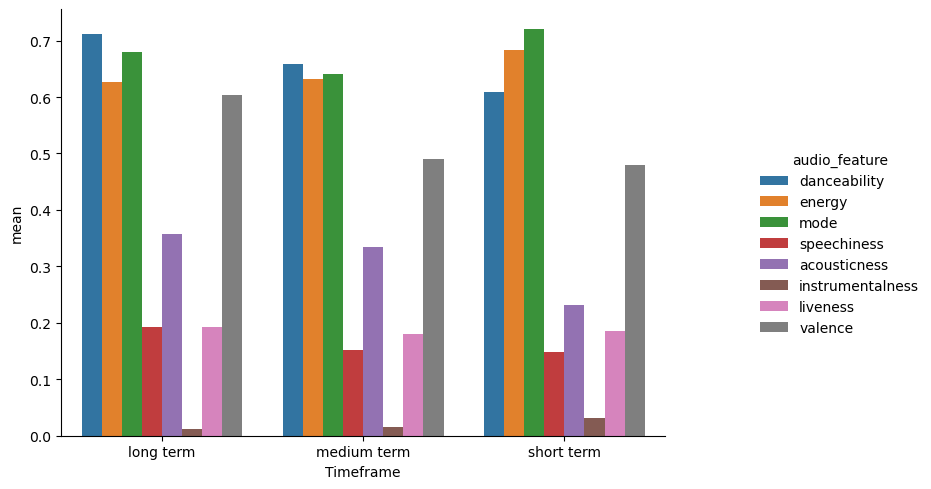

In [26]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data = plot_df, kind = "bar", x = "Timeframe",
            y = "mean", hue = "audio_feature"
)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()